# **Contents**
## [1. Data Loading & Cleaning](1--Data-Loading---Cleaning)
        
    
## [2. Feature Engineering](2--Feature-Engineering)

    
## [3. Analysis](3--Analysis)

<br>

## 1. Data Loading & Cleaning

- Since the CSV files are too big to be manipulated in local RAM, the files are imported manually into database. Subsequently, we need to import libraries to interface with the database (SQLite), for data transformation (numpy, pandas), analysis (sklearn) and visualization (matplotlib, seaborn).


- The schema of the CSV tables are as follow:
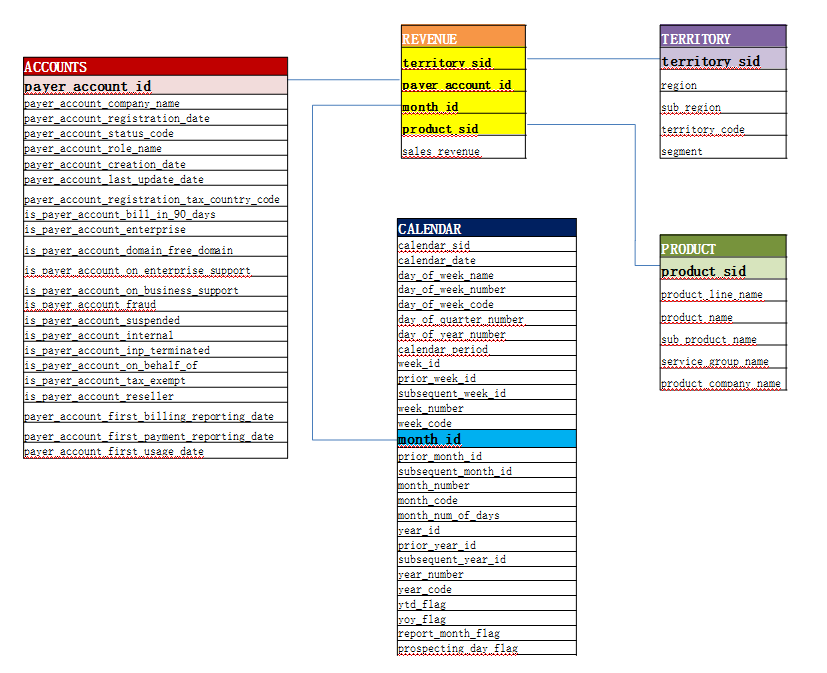

In [12]:
# Basic Libraries
import pandas as pd
import numpy as np
import sqlite3
import os
import itertools
from pathlib import Path
data_folder = Path("C:/Amazon/")

# Feature Scaling
from sklearn.preprocessing import RobustScaler

# Classifier (machine learning algorithm) 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.model_selection import cross_val_score, cross_val_predict

# Parameter Tuning
from sklearn.model_selection import GridSearchCV

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

    # Continuous Data Plot
def cont_plot(df, feature_name, target_name, palettemap, hue_order, feature_scale,titling): 
    df['Counts'] = "" # A trick to skip using an axis (either x or y) on splitting violinplot
    fig, [axis0,axis1] = plt.subplots(1,2,figsize=(10,5))
    sns.distplot(df[feature_name], ax=axis0);
    sns.violinplot(x=feature_name, y="Counts", hue=target_name, hue_order=hue_order, data=df,
                   palette=palettemap, split=True, orient='h', ax=axis1)
    axis1.set_xticks(feature_scale)
    plt.title(titling, fontsize = 24)
    plt.show()
    # WARNING: This will leave Counts column in dataset if you continues to use this dataset

    # Categorical/Ordinal Data Plot
def cat_plot(df, feature_name, target_name, palettemap,titling): 
    fig, [axis0,axis1] = plt.subplots(1,2,figsize=(10,5))
    df[feature_name].value_counts().plot.pie(autopct='%1.1f%%',ax=axis0)
    sns.countplot(x=feature_name, hue=target_name, data=df,
                  palette=palettemap,ax=axis1)
    plt.title(titling, fontsize = 24)
    plt.show()

    
survival_palette = {0: "black", 1: "orange"} # Color map for visualization

  # Confusion matrix plot
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
  
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
#sqlquery
conn = sqlite3.connect('C:/Amazon/Amazon.db')
c = conn.cursor()


- We are counting the distinct levels to categorical fields to determine whether to drop / merge attributes that have too many levels

In [ ]:

########################################  EXPLORATION  ########################################

#count distinct values,

### dim_product ###
#54, 14102, 68, 32, 5407

pd.read_sql("select count(distinct product_line_name) as product_line_name,    \
            count(distinct product_name) as product_name,    \
            count(distinct sub_product_name) as sub_product_name,    \
            count(distinct service_group_name) as service_group_name,    \
            count(distinct product_company_name) as product_company_name    \
            from dim_product"    \
            , con=conn)

### dim_territory ###
#6, 67, 6080, 6
pd.read_sql("select count(distinct region),    \
            count(distinct sub_region),    \
            count(distinct territory_code),    \
            count(distinct segment),    \
            from dim_territory"    \
            , con=conn)

############################################  END  ###########################################  


<br>

## 2. Feature Engineering

<br>
- We create flags on categorical variables

<br>

- Flags are more efficient (space-wise) when performing joins on large datasets and required in feature importance analysis

<br>

In [ ]:
########################################  DATA CLEANING & FEATURE ENGINEERING PT 1  ##############################################

#create new product_sid,old sid missing 1 character (P), not able to join
pd.read_sql("create table dim_account2 as \
            select a.*,     \
                    case when substr(payer_account_id,1,1) = 'A'    \
                    then 'P'||payer_account_id else payer_account_id end as payer_account_id2, \
                    case when payer_account_status_code= 'Suspended' then 1 else 0 end as f_ac_cd_susp,    \
                    case when payer_account_status_code= 'Active' then 1 else 0 end as f_ac_cd_actv,    \
                    case when payer_account_status_code= 'DEV_TOKEN' then 1 else 0 end as f_ac_cd_dev,    \
                    \
                    case when payer_account_role_name= 'Regular' then 1 else 0 end as f_ac_role_reg,    \
                    case when payer_account_role_name= 'Linked' then 1 else 0 end as f_ac_role_link,    \
                    case when payer_account_role_name is null then 1 else 0 end as f_ac_role_null,    \
                    \
                    case when is_payer_account_bill_in_90_days= 'Y' then 1 else 0 end as f_ac_bill90days,    \
                    case when is_payer_account_enterprise= 'Y' then 1 else 0 end as f_ac_ent,    \
                    case when is_payer_account_domain_free_domain= 'Y' then 1 else 0 end as f_ac_freedom,    \
                    case when is_payer_account_on_enterprise_support= 'Y' then 1 else 0 end as f_ac_entsupp,    \
                    case when is_payer_account_on_business_support= 'Y' then 1 else 0 end as f_ac_bizsupp,    \
                    case when is_payer_account_fraud= 'Y' then 1 else 0 end as f_ac_fraud,    \
                    case when is_payer_account_suspended= 'Y' then 1 else 0 end as f_ac_susp,    \
                    case when is_payer_account_internal= 'Y' then 1 else 0 end as f_ac_intrnl,    \
                    case when is_payer_account_inp_terminated= 'Y' then 1 else 0 end as f_ac_term,    \
                    case when is_payer_account_on_behalf_of= 'Y' then 1 else 0 end as f_ac_behalf,    \
                    case when is_payer_account_tax_exempt= 'Y' then 1 else 0 end as f_ac_tax_exempt,    \
                    case when is_payer_account_reseller= 'Y' then 1 else 0 end as f_ac_resell,    \
                    \
                    case when payer_account_status_code = 'Active' then 1 else 0 end as f_ac_active   \
            from dim_account a" , con=conn)


pd.read_sql("create table dim_territory2 as \
            select a.*,    \
                    case when sub_region = 'Sub Region106' then 1 else 0 end as f_subreg_106,    \
                    case when sub_region = 'Sub Region117' then 1 else 0 end as f_subreg_117,    \
                    case when sub_region = 'Sub Region173' then 1 else 0 end as f_subreg_173,    \
                    case when sub_region = 'Sub Region227' then 1 else 0 end as f_subreg_227,    \
                    case when sub_region = 'Sub Region268' then 1 else 0 end as f_subreg_268,     \
                    case when sub_region = 'Sub Region299' then 1 else 0 end as f_subreg_299,    \
                    case when sub_region = 'Sub Region338' then 1 else 0 end as f_subreg_338,    \
                    case when sub_region = 'Sub Region53' then 1 else 0 end as f_subreg_53,    \
                    case when sub_region not in ('Sub Region106',	'Sub Region117',	'Sub Region173',	'Sub Region227',	'Sub Region268',	'Sub Region299',	'Sub Region338',	'Sub Region53')    \
                    then 1 else 0 end as f_subreg_oth,    \
                    \
                    case when segment = 'APAC Segment 5' then 1 else 0 end as f_seg_5,    \
                    case when segment = 'APAC Segment 1'  then 1 else 0 end as f_seg_1,    \
                    case when segment not in ('APAC Segment 5', 'APAC Segment 1')    \
                    then 1 else 0 end as f_seg_oth    \
            from dim_territory a    \
            " , con=conn)

pd.read_sql("create table dim_product2 as \
            select a.*,    \
                    case when product_line_name = 'Product Line 13' then 1 else 0 end as f_pdt_13,   \
                    case when product_line_name = 'Product Line 12'then 1 else 0 end as f_pdt_12,     \
                    case when product_line_name = 'Product Line 10' then 1 else 0 end as f_pdt_10,    \
                    case when product_line_name = 'Product Line 6' then 1 else 0 end as f_pdt_6,    \
                    case when product_line_name not in ('Product Line 13','Product Line 12','Product Line 10','Product Line 6')    \
                    then 1 else 0 end as f_pdt_oth,    \
                    1 as f_pdt,    \
                    \
                    case when sub_product_name = 'Sub Product 67' then 1 else 0 end as f_subpdt_67,    \
                    case when sub_product_name = 'Sub Product 14' then 1 else 0 end as f_subpdt_14,    \
                    case when sub_product_name = 'Sub Product 13' then 1 else 0 end as f_subpdt_13,    \
                    case when sub_product_name = 'Sub Product 12' then 1 else 0 end as f_subpdt_12,    \
                    case when sub_product_name = 'Sub Product 11' then 1 else 0 end as f_subpdt_11,    \
                    case when sub_product_name = 'Sub Product 9' then 1 else 0 end as f_subpdt_9,    \
                    case when sub_product_name = 'Sub Product 2' then 1 else 0 end as f_subpdt_2,    \
                    case when sub_product_name = 'Sub Product 1' then 1 else 0 end as f_subpdt_1,    \
                    case when sub_product_name not in ('Sub Product 67','Sub Product 14','Sub Product 13','Sub Product 12','Sub Product 11','Sub Product 9','Sub Product 2','Sub Product 1')    \
                    then 1 else 0 end as f_subpdt_oth,    \
                    1 as f_subpdt,    \
                    \
                    case when service_group_name = 'Service Group 18' then 1 else 0 end as f_srvgp_18,     \
                    case when service_group_name = 'Service Group 8' then 1 else 0 end as f_srvgp_8,    \
                    case when service_group_name = 'Service Group 9' then 1 else 0 end as f_srvgp_9,     \
                    case when service_group_name = 'Service Group 16' then 1 else 0 end as f_srvgp_16,    \
                    case when service_group_name not in ('Service Group 18',	'Service Group 8',	'Service Group 9',	'Service Group 16')    \
                    then 1 else 0 end as f_srvgp_oth,    \
                    1 as f_srvgp,    \
            from dim_product a    \
            " , con=conn)

#create new revenue table with product lines, service group
pd.read_sql("create table rev_pdt as \
            select a.*,     \
            b.f_pdt_13,    \
            b.f_pdt_12,    \
            b.f_pdt_10,    \
            b.f_pdt_6,    \
            b.f_pdt_oth,    \
            b.f_pdt,    \
            b.f_subpdt_67,    \
            b.f_subpdt_14,    \
            b.f_subpdt_13,    \
            b.f_subpdt_12,    \
            b.f_subpdt_11,    \
            b.f_subpdt_9,    \
            b.f_subpdt_2,    \
            b.f_subpdt_1,    \
            b.f_subpdt_oth,    \
            b.f_subpdt,    \
            b.f_srvgp_18,    \
            b.f_srvgp_8,    \
            b.f_srvgp_9,    \
            b.f_srvgp_16,    \
            b.f_srvgp_oth,    \
            b.f_srvgp,    \
            c.f_subreg_106,    \
            c.f_subreg_117,    \
            c.f_subreg_173,    \
            c.f_subreg_227,    \
            c.f_subreg_268,    \
            c.f_subreg_299,    \
            c.f_subreg_338,    \
            c.f_subreg_53,    \
            c.f_subreg_oth,    \
            c.f_seg_5,    \
            c.f_seg_1,    \
            c.f_seg_oth    \
            from fact_sales_revenue a    \
            left join    \
            dim_product2 b     \
            on a.product_sid = b.product_sid2    \
            left join    \
            dim_territory2 c     \
            on a.territory_sid = c.territory_sid" , con=conn)
#1160280
pd.read_sql("create table rev_summ as \
            select payer_account_id,     \
            month_id,    \
            sum(sales_revenue) as sales_revenue,    \
            sum(f_pdt_13) as v_pdt_13,    \
            sum(f_pdt_12) as v_pdt_12,    \
            sum(f_pdt_10) as v_pdt_10,    \
            sum(f_pdt_6) as v_pdt_6,    \
            sum(f_pdt_oth) as v_pdt_oth,    \
            sum(f_pdt) as v_pdt,    \
            sum(f_subpdt_67) as v_subpdt_67,    \
            sum(f_subpdt_14) as v_subpdt_14,    \
            sum(f_subpdt_13) as v_subpdt_13,    \
            sum(f_subpdt_12) as v_subpdt_12,    \
            sum(f_subpdt_11) as v_subpdt_11,    \
            sum(f_subpdt_9) as v_subpdt_9,    \
            sum(f_subpdt_2) as v_subpdt_2,    \
            sum(f_subpdt_1) as v_subpdt_1,    \
            sum(f_subpdt_oth) as v_subpdt_oth,    \
            sum(f_subpdt) as v_subpdt,    \
            sum(f_srvgp_18) as v_srvgp_18,    \
            sum(f_srvgp_8) as v_srvgp_8,    \
            sum(f_srvgp_9) as v_srvgp_9,    \
            sum(f_srvgp_16) as v_srvgp_16,    \
            sum(f_srvgp_oth) as v_srvgp_oth,    \
            sum(f_srvgp) as v_srvgp,    \
            sum(f_subreg_106) as v_subreg_106,    \
            sum(f_subreg_117) as v_subreg_117,    \
            sum(f_subreg_173) as v_subreg_173,    \
            sum(f_subreg_227) as v_subreg_227,    \
            sum(f_subreg_268) as v_subreg_268,    \
            sum(f_subreg_299) as v_subreg_299,    \
            sum(f_subreg_338) as v_subreg_338,    \
            sum(f_subreg_53) as v_subreg_53,    \
            sum(f_subreg_oth) as v_subreg_oth,    \
            sum(f_seg_5) as v_seg_5,    \
            sum(f_seg_1) as v_seg_1,    \
            sum(f_seg_oth) as v_seg_oth,    \
            case when sum(f_pdt_13)  >=1 then 1 else 0 end as f_pdt_13,    \
            case when sum(f_pdt_12)  >=1 then 1 else 0 end as f_pdt_12,    \
            case when sum(f_pdt_10)  >=1 then 1 else 0 end as f_pdt_10,    \
            case when sum(f_pdt_6)  >=1 then 1 else 0 end as f_pdt_6,    \
            case when sum(f_pdt_oth)  >=1 then 1 else 0 end as f_pdt_oth,    \
            case when sum(f_pdt)  >=1 then 1 else 0 end as f_pdt,    \
            case when sum(f_subpdt_67)  >=1 then 1 else 0 end as f_subpdt_67,    \
            case when sum(f_subpdt_14)  >=1 then 1 else 0 end as f_subpdt_14,    \
            case when sum(f_subpdt_13)  >=1 then 1 else 0 end as f_subpdt_13,    \
            case when sum(f_subpdt_12)  >=1 then 1 else 0 end as f_subpdt_12,    \
            case when sum(f_subpdt_11)  >=1 then 1 else 0 end as f_subpdt_11,    \
            case when sum(f_subpdt_9)  >=1 then 1 else 0 end as f_subpdt_9,    \
            case when sum(f_subpdt_2)  >=1 then 1 else 0 end as f_subpdt_2,    \
            case when sum(f_subpdt_1)  >=1 then 1 else 0 end as f_subpdt_1,    \
            case when sum(f_subpdt_oth)  >=1 then 1 else 0 end as f_subpdt_oth,    \
            case when sum(f_subpdt)  >=1 then 1 else 0 end as f_subpdt,    \
            case when sum(f_srvgp_18)  >=1 then 1 else 0 end as f_srvgp_18,    \
            case when sum(f_srvgp_8)  >=1 then 1 else 0 end as f_srvgp_8,    \
            case when sum(f_srvgp_9)  >=1 then 1 else 0 end as f_srvgp_9,    \
            case when sum(f_srvgp_16)  >=1 then 1 else 0 end as f_srvgp_16,    \
            case when sum(f_srvgp_oth)  >=1 then 1 else 0 end as f_srvgp_oth,    \
            case when sum(f_srvgp)  >=1 then 1 else 0 end as f_srvgp,    \
            case when sum(f_subreg_106)  >=1 then 1 else 0 end as f_subreg_106,    \
            case when sum(f_subreg_117)  >=1 then 1 else 0 end as f_subreg_117,    \
            case when sum(f_subreg_173)  >=1 then 1 else 0 end as f_subreg_173,    \
            case when sum(f_subreg_227)  >=1 then 1 else 0 end as f_subreg_227,    \
            case when sum(f_subreg_268)  >=1 then 1 else 0 end as f_subreg_268,    \
            case when sum(f_subreg_299)  >=1 then 1 else 0 end as f_subreg_299,    \
            case when sum(f_subreg_338)  >=1 then 1 else 0 end as f_subreg_338,    \
            case when sum(f_subreg_53)  >=1 then 1 else 0 end as f_subreg_53,    \
            case when sum(f_subreg_oth)  >=1 then 1 else 0 end as f_subreg_oth,    \
            case when sum(f_seg_5)  >=1 then 1 else 0 end as f_seg_5,    \
            case when sum(f_seg_1)  >=1 then 1 else 0 end as f_seg_1,    \
            case when sum(f_seg_oth)  >=1 then 1 else 0 end as f_seg_oth    \
            from rev_pdt   \
            group by 1,2" , con=conn)
############################################  END  ###########################################  

In [3]:
rev_summ = pd.read_sql("select * \
                        from rev_pdt   \
                        limit 3" , con=conn)
print(rev_summ)

         territory_sid      payer_account_id  month_id            product_sid  \
0  S000000000000006930  PA000000000000021175    201709  PHS000000000000057885   
1  S000000000000006930  PA000000000000021175    201610  PHS000000000000057866   
2  S000000000000006930  PA000000000000021175    201605  PHS000000000000058195   

   sales_revenue  f_pdt_13  f_pdt_12  f_pdt_10  f_pdt_6  f_pdt_oth    ...      \
0        0.00000         1         0         0        0          0    ...       
1        0.02396         0         0         1        0          0    ...       
2        0.05000         1         0         0        0          0    ...       

   f_subreg_173  f_subreg_227  f_subreg_268  f_subreg_299  f_subreg_338  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   

   f_subreg_53  f_subreg_oth  f_seg_5  f_seg_1  f

<br>


- We create churn and baseline attributes early on

<br>
- This is for optimization; customers who are not in baseline cannot churn and are excluded from tables

<br>

In [ ]:
############################################  CREATE CHURN & BASELINE  ###########################################  
#create 2015, 2016, 2017,2018 month_id for baseline of 2015 -> 2018 customers
pd.read_sql("create table base as    \
             select a.payer_account_id, b.month_id, b.year_id, b.calendar_date    \
             from     \
             (select distinct payer_account_id, 1 as placeholder from rev_summ) a    \
             left join   \
             (select *, 1 as placeholder from dim_calendar2) b    \
             on a.placeholder = b.placeholder", con=conn)

#select earliest record per customer
pd.read_sql("create table placeholder as    \
               select payer_account_id, month_id from rev_pdt    \
               group by payer_account_id    \
               having min(month_id)     \
               ", con=conn)
#3,581,524
pd.read_sql("create table base2 as    \
             select * from base a    \
             left join    \
             placeholder b    \
             on a.payer_account_id = b.payer_account_id    \
             where a.month_id >= b.month_id    \
             ", con=conn)
pd.read_sql("create table rev_summ2 as    \
            select a.*,     \
            b.f_ac_cd_susp,    \
            b.f_ac_cd_actv,    \
            b.f_ac_cd_dev,    \
            b.f_ac_role_reg,    \
            b.f_ac_role_link,    \
            b.f_ac_role_null,    \
            b.f_ac_bill90days,    \
            b.f_ac_ent,    \
            b.f_ac_freedom,    \
            b.f_ac_entsupp,    \
            b.f_ac_bizsupp,    \
            b.f_ac_fraud,    \
            b.f_ac_susp,    \
            b.f_ac_intrnl,    \
            b.f_ac_term,    \
            b.f_ac_behalf,    \
            b.f_ac_tax_exempt,    \
            b.f_ac_resell,    \
            b.f_ac_active,    \
            julianday(a.calendar_date) - julianday(b.payer_account_registration_date) as ac_regist_dif,    \
            julianday(a.calendar_date) - julianday(b.payer_account_first_billing_reporting_date) as ac_bill_dif,    \
            julianday(a.calendar_date) - julianday(b.payer_account_first_payment_reporting_date) as ac_pay_dif,  \
            julianday(a.calendar_date) - julianday(b.payer_account_first_usage_date) as ac_use_dif,    \
            julianday(a.calendar_date) - julianday(b.payer_account_creation_date) as ac_create_dif    \
            from base2 a    \
            left join dim_account2 b    \
            on a.payer_account_id = b.payer_account_id2", con=conn)


pd.read_sql("create table rev_summ3 as    \
            select a.*,     \
            c.*    \
            from rev_summ2 a    \
            left join rev_summ b    \
            on a.payer_account_id = b.payer_account_id", con=conn)


pd.read_sql("CREATE UNIQUE INDEX index_name ON rev_summ3    \
            (territory_sid, payer_account_id, product_sid, month_id)    \
            ", con=conn)



#get 201512, 201612, 201712 baseline
pd.read_sql("create table placeholder2 as    \
            select payer_account_id,    \
            case when sum(f_201512) >= 1 then 1 else 0 end as f_201512,    \
            case when sum(f_201612) >= 1 then 1 else 0 end as f_201612,    \
            case when sum(f_201712) >= 1 then 1 else 0 end as f_201712,    \
            sum(rev_201512) as rev_201512,    \
            sum(rev_201612) as rev_201612,    \
            sum(rev_201712) as rev_201712    \
            from   \
            (select payer_account_id, \
            month_id,    \
            count(*) as obs,    \
            case when month_id = 201512 then count(*) else 0 end as f_201512,    \
            case when month_id = 201612 then count(*) else 0 end as f_201612,    \
            case when month_id = 201712 then count(*) else 0 end as f_201712,    \
            case when month_id = 201512 then sum(sales_revenue) else 0 end as rev_201512,    \
            case when month_id = 201612 then sum(sales_revenue) else 0 end as rev_201612,    \
            case when month_id = 201712 then sum(sales_revenue) else 0 end as rev_201712    \
            from rev_summ3  \
            where month_id in (201512,201612,201712) group by 1,2)    \
            group by 1    \
            ", con=conn)     
            

#create churn
pd.read_sql("create table rev_summ4 as    \
            select a.*,     \
            b.rev_201512,    \
            b.rev_201612,    \
            b.rev_201712,    \
            case when substr(a.month_id,1,4) = '2015' then 0 \
                 when substr(a.month_id,1,4) = '2016' and (rev_201512 >1 and (sales_revenue <1 or sales_revenue is null)) then 1\
                 when substr(a.month_id,1,4) = '2017' and (rev_201612 >1 and (sales_revenue <1 or sales_revenue is null)) then 1\
                 when substr(a.month_id,1,4) = '2018' and (rev_201712 >1 and (sales_revenue <1 or sales_revenue is null)) then 1\
                 else 0 end as f_churn,    \
            case when substr(a.month_id,1,4) = '2015' then 0 \
                 when substr(a.month_id,1,4) = '2016' and rev_201512 >1 then 1\
                 when substr(a.month_id,1,4) = '2017' and rev_201612 >1 then 1\
                 when substr(a.month_id,1,4) = '2018' and rev_201712 >1) then 1\
                 else 0 end as f_baseline    \
            from rev_summ3  a    \
            left join placeholder2 b   \
            on a.payer_account_id = b.payer_account_id    \
            ", con=conn)

#select earliest churn record per customer
df = pd.read_sql("create table placeholder3 as    \
                 select a.payer_account_id, a.month_id, b.prior_month_id from    \
                (select payer_account_id, month_id from rev_summ4    \
               where f_churn = 1    \
               group by payer_account_id    \
               having min(month_id)) a     \
               left join  \
               (select distinct month_id, prior_month_id from dim_calendar) b    \
               on a.month_id = b.month_id    \
               ", con=conn)


pd.read_sql("create table rev_summ5 as    \
            select a.*,     \
            case when a.month_id = b.month_id then 1 else 0 end as f_first_churn    \
            case when a.month_id = c.prior_month_id then 1 else 0 end as f_prior_churn    \
            from rev_summ4  a    \
            left join placeholder3 b   \
            on a.payer_account_id = b.payer_account_id    \
            and a.month_id = b.month_id    \
            left join placeholder3 c   \
            on a.payer_account_id = c.payer_account_id    \
            and a.month_id = c.prior_month_id    \

            ", con=conn)


############################################################  END  ########################################################  


<br>


- We perform additional feature engineering

<br>
- Data is aggregated at yearly and monthly levels to create YoY/ QoQ % Change attributes

<br>
- Flags are summed up to create 'volume' attributes

<br>


In [10]:
########################################  DATA CLEANING & FEATURE ENGINEERING PT 2  ##############################################

#yearly summary to create yearly % change variable
pd.read_sql("create table summ_yr as    \
            select payer_account_id,   \
            substr(month_id,1,4) as year,     \
            sum(sales_revenue) as sales_revenue_yr,   \
            sum(f_ac_active) as v_ac_active_yr,    \
            sum(f_pdt_13) as v_pdt_13_yr,    \
            sum(f_pdt_12) as v_pdt_12_yr,    \
            sum(f_pdt_10) as v_pdt_10_yr,    \
            sum(f_pdt_6) as v_pdt_6_yr,    \
            sum(f_pdt_oth) as v_pdt_oth_yr,    \
            sum(f_pdt) as v_pdt_yr,    \
            sum(f_subpdt_67) as v_subpdt_67_yr,    \
            sum(f_subpdt_14) as v_subpdt_14_yr,    \
            sum(f_subpdt_13) as v_subpdt_13_yr,    \
            sum(f_subpdt_12) as v_subpdt_12_yr,    \
            sum(f_subpdt_11) as v_subpdt_11_yr,    \
            sum(f_subpdt_9) as v_subpdt_9_yr,    \
            sum(f_subpdt_2) as v_subpdt_2_yr,    \
            sum(f_subpdt_1) as v_subpdt_1_yr,    \
            sum(f_subpdt_oth) as v_subpdt_oth_yr,    \
            sum(f_subpdt) as v_subpdt_yr,    \
            sum(f_srvgp_18) as v_srvgp_18_yr,    \
            sum(f_srvgp_8) as v_srvgp_8_yr,    \
            sum(f_srvgp_9) as v_srvgp_9_yr,    \
            sum(f_srvgp_16) as v_srvgp_16_yr,    \
            sum(f_srvgp_oth) as v_srvgp_oth_yr,    \
            sum(f_subreg_106) as v_subreg_106_yr,    \
            sum(f_subreg_117) as v_subreg_117_yr,    \
            sum(f_subreg_173) as v_subreg_173_yr,    \
            sum(f_subreg_227) as v_subreg_227_yr,    \
            sum(f_subreg_268) as v_subreg_268_yr,    \
            sum(f_subreg_299) as v_subreg_299_yr,    \
            sum(f_subreg_338) as v_subreg_338_yr,    \
            sum(f_subreg_53) as v_subreg_53_yr,    \
            sum(f_subreg_oth) as v_subreg_oth_yr,    \
            sum(f_seg_5) as v_seg_5_yr,    \
            sum(f_seg_1) as v_seg_1_yr,    \
            sum(f_seg_oth) as v_seg_oth_yr,    \
            case when sum(f_ac_active) >= 1 then 1 else 0 end as f_ac_active_yr,    \
            case when sum(f_pdt_13) >= 1 then 1 else 0 end as f_pdt_13_yr,    \
            case when sum(f_pdt_12) >= 1 then 1 else 0 end as f_pdt_12_yr,    \
            case when sum(f_pdt_10) >= 1 then 1 else 0 end as f_pdt_10_yr,    \
            case when sum(f_pdt_6) >= 1 then 1 else 0 end as f_pdt_6_yr,    \
            case when sum(f_pdt_oth) >= 1 then 1 else 0 end as f_pdt_oth,    \
            case when sum(f_pdt) >= 1 then 1 else 0 end as f_pdt_yr,    \
            case when sum(f_subpdt_67) >= 1 then 1 else 0 end as f_subpdt_67_yr,    \
            case when sum(f_subpdt_14) >= 1 then 1 else 0 end as f_subpdt_14_yr,    \
            case when sum(f_subpdt_13) >= 1 then 1 else 0 end as f_subpdt_13_yr,    \
            case when sum(f_subpdt_12) >= 1 then 1 else 0 end as f_subpdt_12_yr,    \
            case when sum(f_subpdt_11) >= 1 then 1 else 0 end as f_subpdt_11_yr,    \
            case when sum(f_subpdt_9) >= 1 then 1 else 0 end as f_subpdt_9_yr,    \
            case when sum(f_subpdt_2) >= 1 then 1 else 0 end as f_subpdt_2_yr,    \
            case when sum(f_subpdt_1) >= 1 then 1 else 0 end as f_subpdt_1_yr,    \
            case when sum(f_subpdt_oth) >= 1 then 1 else 0 end as f_subpdt_oth_yr,    \
            case when sum(f_subpdt) >= 1 then 1 else 0 end as f_subpdt,    \
            case when sum(f_srvgp_18) >= 1 then 1 else 0 end as f_srvgp_18_yr,    \
            case when sum(f_srvgp_8) >= 1 then 1 else 0 end as f_srvgp_8_yr,    \
            case when sum(f_srvgp_9) >= 1 then 1 else 0 end as f_srvgp_9_yr,    \
            case when sum(f_srvgp_16) >= 1 then 1 else 0 end as f_srvgp_16_yr,    \
            case when sum(f_srvgp_oth) >= 1 then 1 else 0 end as f_srvgp_oth_yr,    \
            case when sum(f_subreg_106) >= 1 then 1 else 0 end as f_subreg_106_yr,    \
            case when sum(f_subreg_117) >= 1 then 1 else 0 end as f_subreg_117_yr,    \
            case when sum(f_subreg_173) >= 1 then 1 else 0 end as f_subreg_173_yr,    \
            case when sum(f_subreg_227) >= 1 then 1 else 0 end as f_subreg_227_yr,    \
            case when sum(f_subreg_268) >= 1 then 1 else 0 end as f_subreg_268_yr,    \
            case when sum(f_subreg_299) >= 1 then 1 else 0 end as f_subreg_299_yr,    \
            case when sum(f_subreg_338) >= 1 then 1 else 0 end as f_subreg_338_yr,    \
            case when sum(f_subreg_53) >= 1 then 1 else 0 end as f_subreg_53_yr,    \
            case when sum(f_subreg_oth) >= 1 then 1 else 0 end as f_subreg_oth_yr,    \
            case when sum(f_seg_5) >= 1 then 1 else 0 end as f_seg_5_yr,    \
            case when sum(f_seg_1) >= 1 then 1 else 0 end as f_seg_1_yr,     \
            case when sum(f_seg_oth) >= 1 then 1 else 0 end as f_seg_oth_yr    \
            from summ_mth3     \
            group by 1, 2", con=conn)

###quarterly summary to create quarterly % change variable
pd.read_sql("create table summ_qtr as    \
            select payer_account_id,  \
            case when substr(month_id,5,2) in ('01','02','03') then cast(substr(month_id,1,4)||'03' as int)   \
                 when substr(month_id,5,2) in ('04','05','06') then cast(substr(month_id,1,4)||'06' as int)    \
                 when substr(month_id,5,2) in ('07','08','09') then cast(substr(month_id,1,4)||'09' as int)    \
                 when substr(month_id,5,2) in ('10','11','12') then cast(substr(month_id,1,4)||'12' as int)    \
                 end as quarters,\
            sum(sales_revenue) as sales_revenue_qtr,   \
            sum(f_ac_active) as v_ac_active_qtr,    \
            sum(f_pdt_13) as v_pdt_13_qtr,    \
            sum(f_pdt_12) as v_pdt_12_qtr,    \
            sum(f_pdt_10) as v_pdt_10_qtr,    \
            sum(f_pdt_6) as v_pdt_6_qtr,    \
            sum(f_pdt_oth) as v_pdt_oth_qtr,    \
            sum(f_pdt) as v_pdt_qtr,    \
            sum(f_subpdt_67) as v_subpdt_67_qtr,    \
            sum(f_subpdt_14) as v_subpdt_14_qtr,    \
            sum(f_subpdt_13) as v_subpdt_13_qtr,    \
            sum(f_subpdt_12) as v_subpdt_12_qtr,    \
            sum(f_subpdt_11) as v_subpdt_11_qtr,    \
            sum(f_subpdt_9) as v_subpdt_9_qtr,    \
            sum(f_subpdt_2) as v_subpdt_2_qtr,    \
            sum(f_subpdt_1) as v_subpdt_1_qtr,    \
            sum(f_subpdt_oth) as v_subpdt_oth_qtr,    \
            sum(f_subpdt) as v_subpdt_qtr,    \
            sum(f_srvgp_18) as v_srvgp_18_qtr,    \
            sum(f_srvgp_8) as v_srvgp_8_qtr,    \
            sum(f_srvgp_9) as v_srvgp_9_qtr,    \
            sum(f_srvgp_16) as v_srvgp_16_qtr,    \
            sum(f_srvgp_oth) as v_srvgp_oth_qtr,    \
            sum(f_subreg_106) as v_subreg_106_qtr,    \
            sum(f_subreg_117) as v_subreg_117_qtr,    \
            sum(f_subreg_173) as v_subreg_173_qtr,    \
            sum(f_subreg_227) as v_subreg_227_qtr,    \
            sum(f_subreg_268) as v_subreg_268_qtr,    \
            sum(f_subreg_299) as v_subreg_299_qtr,    \
            sum(f_subreg_338) as v_subreg_338_qtr,    \
            sum(f_subreg_53) as v_subreg_53_qtr,    \
            sum(f_subreg_oth) as v_subreg_oth_qtr,    \
            sum(f_seg_5) as v_seg_5_qtr,    \
            sum(f_seg_1) as v_seg_1_qtr,    \
            sum(f_seg_oth) as v_seg_oth_qtr,    \
            case when sum(f_ac_active) >= 1 then 1 else 0 end as f_ac_active_qtr,    \
            case when sum(f_pdt_13) >= 1 then 1 else 0 end as f_pdt_13_qtr,    \
            case when sum(f_pdt_12) >= 1 then 1 else 0 end as f_pdt_12_qtr,    \
            case when sum(f_pdt_10) >= 1 then 1 else 0 end as f_pdt_10_qtr,    \
            case when sum(f_pdt_6) >= 1 then 1 else 0 end as f_pdt_6_qtr,    \
            case when sum(f_pdt_oth) >= 1 then 1 else 0 end as f_pdt_oth,    \
            case when sum(f_pdt) >= 1 then 1 else 0 end as f_pdt_qtr,    \
            case when sum(f_subpdt_67) >= 1 then 1 else 0 end as f_subpdt_67_qtr,    \
            case when sum(f_subpdt_14) >= 1 then 1 else 0 end as f_subpdt_14_qtr,    \
            case when sum(f_subpdt_13) >= 1 then 1 else 0 end as f_subpdt_13_qtr,    \
            case when sum(f_subpdt_12) >= 1 then 1 else 0 end as f_subpdt_12_qtr,    \
            case when sum(f_subpdt_11) >= 1 then 1 else 0 end as f_subpdt_11_qtr,    \
            case when sum(f_subpdt_9) >= 1 then 1 else 0 end as f_subpdt_9_qtr,    \
            case when sum(f_subpdt_2) >= 1 then 1 else 0 end as f_subpdt_2_qtr,    \
            case when sum(f_subpdt_1) >= 1 then 1 else 0 end as f_subpdt_1_qtr,    \
            case when sum(f_subpdt_oth) >= 1 then 1 else 0 end as f_subpdt_oth_qtr,    \
            case when sum(f_subpdt) >= 1 then 1 else 0 end as f_subpdt,    \
            case when sum(f_srvgp_18) >= 1 then 1 else 0 end as f_srvgp_18_qtr,    \
            case when sum(f_srvgp_8) >= 1 then 1 else 0 end as f_srvgp_8_qtr,    \
            case when sum(f_srvgp_9) >= 1 then 1 else 0 end as f_srvgp_9_qtr,    \
            case when sum(f_srvgp_16) >= 1 then 1 else 0 end as f_srvgp_16_qtr,    \
            case when sum(f_srvgp_oth) >= 1 then 1 else 0 end as f_srvgp_oth_qtr,    \
            case when sum(f_subreg_106) >= 1 then 1 else 0 end as f_subreg_106_qtr,    \
            case when sum(f_subreg_117) >= 1 then 1 else 0 end as f_subreg_117_qtr,    \
            case when sum(f_subreg_173) >= 1 then 1 else 0 end as f_subreg_173_qtr,    \
            case when sum(f_subreg_227) >= 1 then 1 else 0 end as f_subreg_227_qtr,    \
            case when sum(f_subreg_268) >= 1 then 1 else 0 end as f_subreg_268_qtr,    \
            case when sum(f_subreg_299) >= 1 then 1 else 0 end as f_subreg_299_qtr,    \
            case when sum(f_subreg_338) >= 1 then 1 else 0 end as f_subreg_338_qtr,    \
            case when sum(f_subreg_53) >= 1 then 1 else 0 end as f_subreg_53_qtr,    \
            case when sum(f_subreg_oth) >= 1 then 1 else 0 end as f_subreg_oth_qtr,    \
            case when sum(f_seg_5) >= 1 then 1 else 0 end as f_seg_5_qtr,    \
            case when sum(f_seg_1) >= 1 then 1 else 0 end as f_seg_1_qtr,     \
            case when sum(f_seg_oth) >= 1 then 1 else 0 end as f_seg_oth_qtr    \
            from summ_mth3     \
            group by 1, 2", con=conn)

#create % change change variable; current_mth_var - rollback_x_window_var
def pct_change (df,key,window):
    for i in varlist:
        df[i+'_'+str(window)+'pct']=  np.where(df[key]!=df[key].shift(window), 0, abs(df[i]/df[i].shift(window)-1))

#rolling sum year, % change YoY
year = pd.read_sql("select * from summ_yr", con=conn)
varlist = ["v_pdt_13_yr",	"v_pdt_12_yr",	"v_pdt_10_yr",	"v_pdt_6_yr",	"v_pdt_oth_yr",	"v_pdt_yr",	"v_subpdt_67_yr",	"v_subpdt_14_yr",	"v_subpdt_13_yr",	"v_subpdt_12_yr",	"v_subpdt_11_yr",	"v_subpdt_9_yr",	"v_subpdt_2_yr",	"v_subpdt_1_yr",	"v_subpdt_oth_yr",	"v_subpdt_yr",	"v_srvgp_18_yr",	"v_srvgp_8_yr",	"v_srvgp_9_yr",	"v_srvgp_16_yr",	"v_srvgp_oth_yr","sales_revenue_yr"]
pct_change(year,'payer_account_id',1)
year.replace(np.inf, 0).to_sql(name='final_year', con=conn)

#rolling sum qtr, % change QoQ
qtr =  pd.read_sql("select * from summ_qtr", con=conn)
varlist = ["v_pdt_13_qtr",	"v_pdt_12_qtr",	"v_pdt_10_qtr",	"v_pdt_6_qtr",	"v_pdt_oth_qtr",	"v_pdt_qtr",	"v_subpdt_67_qtr",	"v_subpdt_14_qtr",	"v_subpdt_13_qtr",	"v_subpdt_12_qtr",	"v_subpdt_11_qtr",	"v_subpdt_9_qtr",	"v_subpdt_2_qtr",	"v_subpdt_1_qtr",	"v_subpdt_oth_qtr",	"v_subpdt_qtr",	"v_srvgp_18_qtr",	"v_srvgp_8_qtr",	"v_srvgp_9_qtr",	"v_srvgp_16_qtr",	"v_srvgp_oth_qtr","sales_revenue_qtr"]
pct_change(qtr,'payer_account_id',1)
qtr.replace(np.inf, 0).to_sql(name='final_qtr', con=conn)

#final mthly dataset
pd.read_sql("create table rev_summ6 as    \
            select a.*,     \
            b.v_pdt_13_yr_1pct,     \
            b.v_pdt_12_yr_1pct,     \
            b.v_pdt_10_yr_1pct,     \
            b.v_pdt_6_yr_1pct,     \
            b.v_pdt_oth_yr_1pct,     \
            b.v_pdt_yr_1pct,     \
            b.v_subpdt_67_yr_1pct,     \
            b.v_subpdt_14_yr_1pct,     \
            b.v_subpdt_13_yr_1pct,     \
            b.v_subpdt_12_yr_1pct,     \
            b.v_subpdt_11_yr_1pct,     \
            b.v_subpdt_9_yr_1pct,     \
            b.v_subpdt_2_yr_1pct,     \
            b.v_subpdt_1_yr_1pct,     \
            b.v_subpdt_oth_yr_1pct,     \
            b.v_subpdt_yr_1pct,     \
            b.v_srvgp_18_yr_1pct,     \
            b.v_srvgp_8_yr_1pct,     \
            b.v_srvgp_9_yr_1pct,     \
            b.v_srvgp_16_yr_1pct,     \
            b.v_srvgp_oth_yr_1pct,     \
            b.sales_revenue_yr_1pct,     \
            \
            c.v_pdt_13_qtr_1pct,     \
            c.v_pdt_12_qtr_1pct,     \
            c.v_pdt_10_qtr_1pct,     \
            c.v_pdt_6_qtr_1pct,     \
            c.v_pdt_oth_qtr_1pct,     \
            c.v_pdt_qtr_1pct,     \
            c.v_subpdt_67_qtr_1pct,     \
            c.v_subpdt_14_qtr_1pct,     \
            c.v_subpdt_13_qtr_1pct,     \
            c.v_subpdt_12_qtr_1pct,     \
            c.v_subpdt_11_qtr_1pct,     \
            c.v_subpdt_9_qtr_1pct,     \
            c.v_subpdt_2_qtr_1pct,     \
            c.v_subpdt_1_qtr_1pct,     \
            c.v_subpdt_oth_qtr_1pct,     \
            c.v_subpdt_qtr_1pct,     \
            c.v_srvgp_18_qtr_1pct,     \
            c.v_srvgp_8_qtr_1pct,     \
            c.v_srvgp_9_qtr_1pct,     \
            c.v_srvgp_16_qtr_1pct,     \
            c.v_srvgp_oth_qtr_1pct     \
            \
            from rev_summ5  a    \
            \
            left join final_year b   \
            on a.payer_account_id = b.payer_account_id    \
            and substr(a.month_id,1,6) = cast(b.year||'12' as int)    \
            \
            left join final_qtr c   \
            on a.payer_account_id = c.payer_account_id    \
            and substr(a.month_id,1,6) = c.quarters    \
            ", con=conn)

check_results = pd.read_sql("select month_id,sales_revenue,    \
                        rev_201512, f_churn, f_first_churn, f_prior_churn \
                        from rev_summ6   \
                        where payer_account_id = 'PA000000000000082798'   \
                        limit 17    \
                        " , con=conn)
print(check_results)

    month_id  sales_revenue  rev_201512  f_churn  f_first_churn  f_prior_churn
0     201501    1091.923480   3180.4352        0              0              0
1     201502    5049.779999   3180.4352        0              0              0
2     201503   15689.170799   3180.4352        0              0              0
3     201504     194.960000   3180.4352        0              0              0
4     201505     146.200000   3180.4352        0              0              0
5     201506      84.650000   3180.4352        0              0              0
6     201507     102.380000   3180.4352        0              0              0
7     201508       2.970000   3180.4352        0              0              0
8     201509       2.970000   3180.4352        0              0              0
9     201510       2.970000   3180.4352        0              0              0
10    201511     433.300000   3180.4352        0              0              0
11    201512    3180.435200   3180.4352        0    

<br>


- Revenue table is from period of 2015 to 2018.

<br>


- 2015 baseline cannot be established (no 2014 revenue data) and therefore not selected in feature importance analysis

<br>
- A separate file is output for Qlikview visualization


<br>

In [ ]:
#################################  Explanatory Variable Analysis  ##################################### 

#monthly dataset to approximate baseline and churn
monthly =  pd.read_sql("select *     \
                      from summ_mth5    \
                      where substr(month_id,1,4) in ('2016','2017','2018')\
                      and f_baseline = 1    \
                      ", con=conn)
#upload for dashboard QV visualization
monthly.replace(np.inf, 0).to_sql(name='qv_mthly', con=conn)

#create separate dataset for explanatory variables, choose only latest record from each customer
varsel =  pd.read_sql("select *     \
                      from summ_mth5    \
                      where substr(month_id,1,4) in ('2016','2017','2018')\
                      and f_baseline = 1    \
                      group by payer_account_id    \
                      having max(month_id)    \
                      ", con=conn)

varsel = varsel.fillna(0)


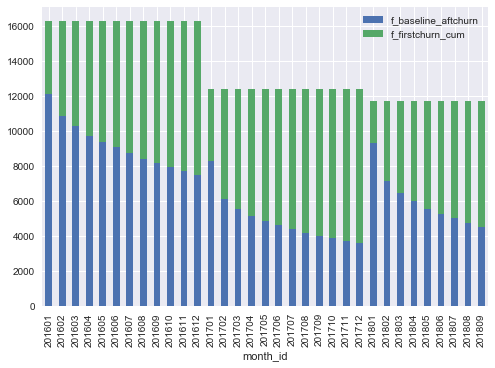

In [6]:
#################################  Visualize monthly churn & baseline  ##################################### 

#monthly dataset to approximate baseline and churn
monthly =  pd.read_sql("select *, f_baseline-f_churn as f_baseline_aftchurn     \
                      from rev_summ6    \
                      where substr(month_id,1,4) in ('2016','2017','2018')\
                      and f_baseline = 1    \
                      ", con=conn)

monthly = monthly.fillna(0)


visual_mth = monthly[['f_baseline','f_first_churn']].groupby(monthly['month_id']).sum()
visual_mth.reset_index(inplace=True)
visual_mth['year'] = visual_mth['month_id'].apply(str).str[:4].astype(int)
visual_mth['f_firstchurn_cum'] = visual_mth['f_first_churn'].groupby(visual_mth['year']).cumsum()
visual_mth['f_baseline_aftchurn'] = visual_mth['f_baseline'] - visual_mth['f_firstchurn_cum']
visual_mth = visual_mth.drop(['f_baseline','f_first_churn','year'], axis=1)
visual_mth = visual_mth[['month_id','f_baseline_aftchurn','f_firstchurn_cum']].set_index('month_id')
visual_mth.plot.bar(stacked=True)
plt.show()


In [7]:
#################################### FEATURE IMPORTANCE #######################################################
#drop redundant variables, partition into predictor and prediction vars

# churn custs, 1 month before churning
churn = pd.read_sql("select *     \
                      from rev_summ6    \
                      where substr(month_id,1,4) in ('2016','2017','2018')\
                      and f_baseline = 1    \
                      and f_prior_churn = 1    \
                      ", con=conn)

# non-churn custs latest instance
existing = pd.read_sql("select *     \
                      from rev_summ6    \
                      where substr(month_id,1,4) in ('2016','2017','2018')\
                      and f_baseline = 1    \
                      and payer_account_id not in    \
                      \
                      (select distinct payer_account_id    \
                      from rev_summ6    \
                      where substr(month_id,1,4) in ('2016','2017','2018')\
                      and f_baseline = 1    \
                      and f_prior_churn = 1)    \
                      \
                      group by payer_account_id    \
                      having max(month_id)    \
                      ", con=conn)

#combine datasets
varsel = pd.concat([churn, existing])
varsel = varsel.fillna(0)

#drop redundant variables, partition into predictor and prediction vars
droplist = ["f_prior_churn","v_pdt_13",	"v_pdt_12",	"v_pdt_10",	"v_pdt_6",	"v_pdt_oth",	"v_pdt",	"v_subpdt_67",	"v_subpdt_14",	"v_subpdt_13",	"v_subpdt_12",	"v_subpdt_11",	"v_subpdt_9",	"v_subpdt_2",	"v_subpdt_1",	"v_subpdt_oth",	"v_subpdt","f_churn","rev_201712","rev_201612","rev_201512","sales_revenue","payer_account_id", "payer_account_id:1","payer_account_id:2",	"month_id","month_id:1","month_id:2","year_id", "calendar_date",	"payer_account_id:1","f_first_churn","v_srvgp","v_srvgp_oth_yr_1pct"]

X_train = varsel.drop(droplist, axis=1)
y_train = varsel['f_prior_churn'] 

<br>

## 3. Analysis
<br>


- We use random forest (a type of decision tree) to split target variable

<br>


- In random forest, the Gini measure is used to determine feature importance. A variable is considered to be significant if it results
in class purity on a split.

<br>
- Illustration:
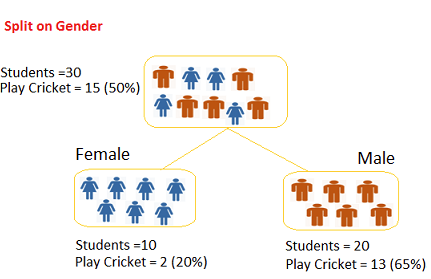

<br>

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


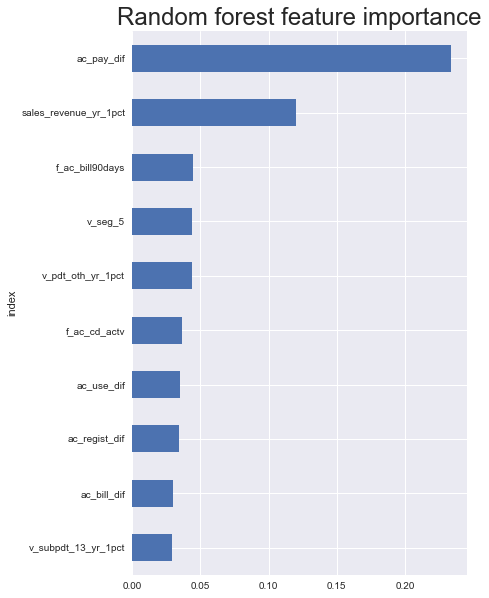

In [8]:
#variable importance
rforest_checker = RandomForestClassifier(random_state = 0)
rforest_checker.fit(X_train, y_train)

importances_df = pd.DataFrame(rforest_checker.feature_importances_, columns=['Feature_Importance'],
                              index=X_train.columns)
importances_df.sort_values(by=['Feature_Importance'], ascending=False, inplace=True)
importances_df.reset_index(inplace=True)

# Plot the relative importance of the top 10 features
df_ = importances_df[0:10]
df_.sort_values('Feature_Importance', ascending = True, inplace = True)
df_.plot(kind='barh', x='index', y='Feature_Importance', legend=False, figsize=(6, 10))
plt.title('Random forest feature importance', fontsize = 24)
plt.show()



C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


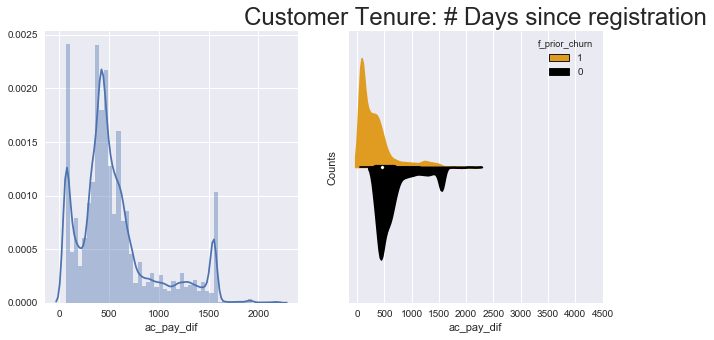

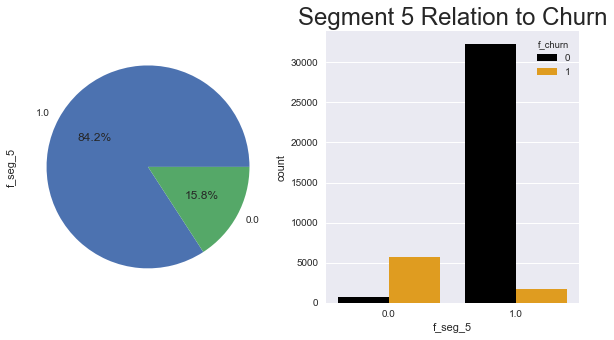

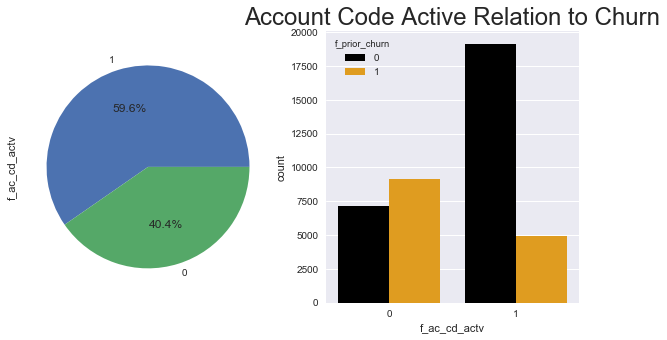

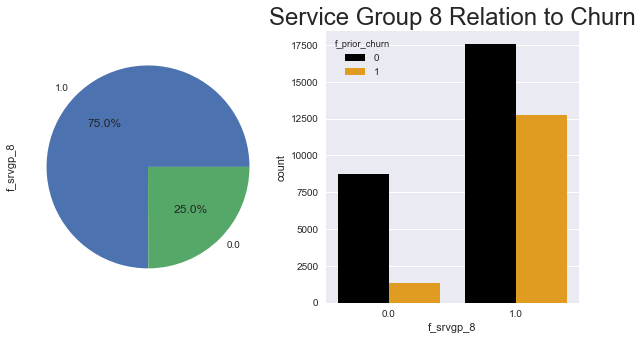

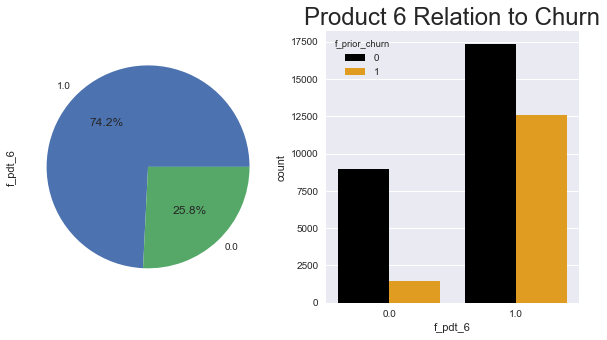

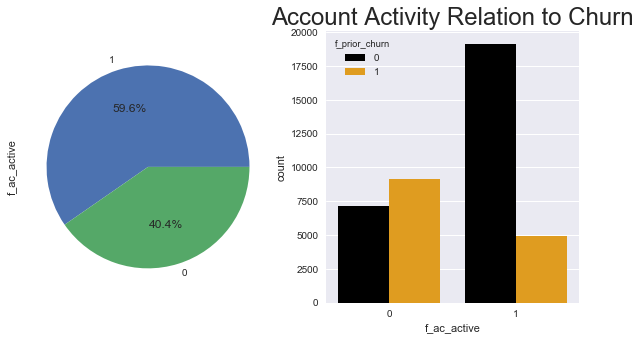

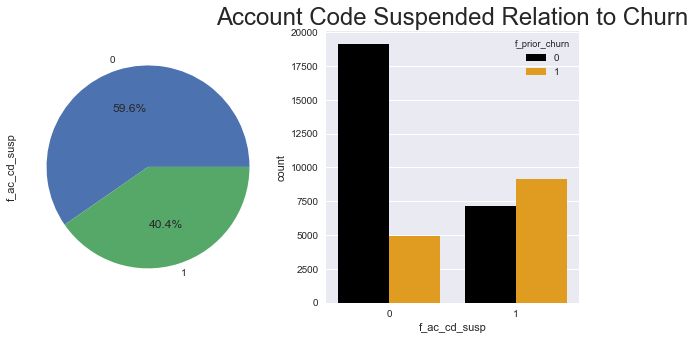

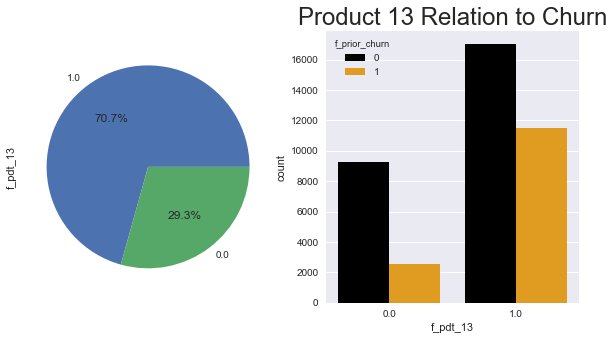

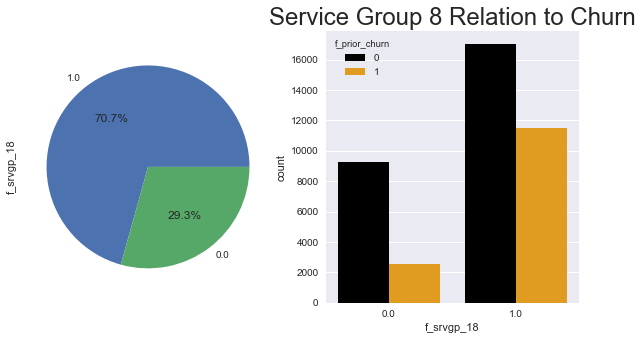

In [22]:
#see relation of variables to churn
cont_plot(varsel, 'ac_pay_dif', 'f_prior_churn', survival_palette, [1, 0], range(0,5000,500),"Customer Tenure: # Days since registration")
cat_plot(varsel, 'f_seg_5', 'f_churn', survival_palette,"Segment 5 Relation to Churn")
cat_plot(varsel, 'f_ac_cd_actv', 'f_prior_churn', survival_palette,"Account Code Active Relation to Churn")
cat_plot(varsel, 'f_srvgp_8', 'f_prior_churn', survival_palette,"Service Group 8 Relation to Churn")
cat_plot(varsel, 'f_pdt_6', 'f_prior_churn', survival_palette,"Product 6 Relation to Churn")
cat_plot(varsel, 'f_ac_active', 'f_prior_churn', survival_palette,"Account Activity Relation to Churn")
cat_plot(varsel, 'f_ac_cd_susp', 'f_prior_churn', survival_palette,"Account Code Suspended Relation to Churn")
cat_plot(varsel, 'f_pdt_13', 'f_prior_churn', survival_palette,"Product 13 Relation to Churn")
cat_plot(varsel, 'f_srvgp_18', 'f_prior_churn', survival_palette,"Service Group 8 Relation to Churn")


In [9]:
#fit top 10 important features to see how well the factors allow us to explain churn

X_train = varsel[list(importances_df['index'].values)]
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train ,test_size=0.3, random_state=0)

rforest_checker = RandomForestClassifier(n_estimators = 30, 
                              random_state = 2017, 
                              oob_score = True, 
                              max_features = 10,
                              min_samples_leaf = 8)

rforest_checker.fit(X_train, y_train)

from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix
y_pred = rforest_checker.predict(X_test)
print(len(X_test))
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

12111
0.962430847989
0.971845148316
0.918507959135
[[7790  112]
 [ 343 3866]]


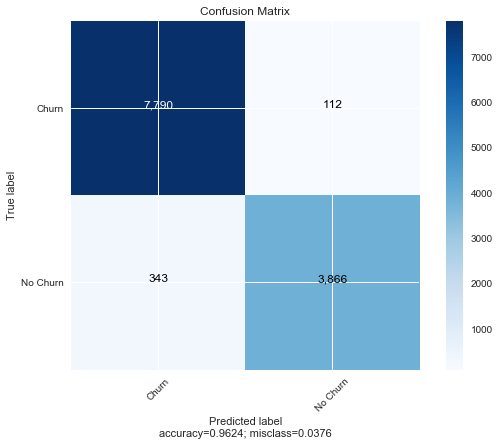

In [14]:
plot_confusion_matrix(cm           = np.array([[ 7790, 112],
                                              [  343,  3866]]), 
                      normalize    = False,
                      target_names = ['Churn', 'No Churn'],
                      title        = "Confusion Matrix")   